In [1]:
import seaborn as sns

sns.set_theme(
    rc={"axes.spines.top": False, "axes.spines.right": False, "figure.autolayout": True},
    style="ticks",
)

# Fisher matrix

Let's start by getting the `MFLike` instance from the first [tutorial](tutorial_loading.ipynb)

In [2]:
%run tutorial_loading.ipynb

     Numpy : 1.26.4
Matplotlib : 3.8.3
      CAMB : 1.5.4
    Cobaya : 3.5
[install] Installing external packages at '/tmp/LAT_packages'

likelihood:mflike.MFLike

[install] Checking if dependencies have already been installed...
[install] External dependencies for this component already installed.
[install] Doing nothing.

* Summary * 

[install] All requested components' dependencies correctly installed at /tmp/LAT_packages
[camb] `camb` module loaded successfully from /home/garrido/Workdir/cmb/development/LAT_MFLike/pyenv/lib/python3.11/site-packages/camb
[mflike.mflike] Number of bins used: 3087
[mflike.mflike] Initialized!


Even if we do not need priors to compute Fisher matrix, we need to fool `cobaya` in order to change parameter values. We set the prior values to &plusmn; 10% around the central value (or to a fixed window for parameters whose default is 0). 

In [3]:
def fake_priors(value):
    if value == 0:
        min, max = -0.5, +0.5
    else:
        min, max = np.array([0.9, 1.1]) * value
    if value < 0:
        min, max = max, min
    return dict(min=min, max=max)


sampled_params = cosmo_params | fg_params | nuisance_params
sampled_params.update({k: dict(prior=fake_priors(v)) for k, v in sampled_params.items()})

Then we define a new model (after having close the previous one to release memory allocation) and
get the `MFLike` likelihood

We are setting low accuracy parameters for this section, since it would otherwise take much more time


In [4]:
from cobaya.model import get_model

info = {
    "params": sampled_params,
    "likelihood": mflike_config,
    "theory": {"camb": {"extra_args": {"lens_potential_accuracy": 1}}},
    "packages_path": packages_path,
}

model = get_model(info)
mflike = model.likelihood["mflike.MFLike"]

[camb] `camb` module loaded successfully from /home/garrido/Workdir/cmb/development/LAT_MFLike/pyenv/lib/python3.11/site-packages/camb
[mflike.mflike] Number of bins used: 3087
[mflike.mflike] Initialized!


Given the sampled parameters, we now set the defaults value of parameters in the same order as the
`cobaya`'s one



In [5]:
default_values = cosmo_params | fg_params | nuisance_params
defaults = {k: default_values[k] for k in model.parameterization.sampled_params()}

and we define the list of Fisher parameters, removing from the list the parameters we don't want to perturb (for example, all the nuisance parameters + `Alens` and some temperature foreground values)

In [6]:
fisher_params = [
    par for par in defaults if par not in ["Alens", "T_d", "T_effd"] + list(nuisance_params)
]

For each parameter, we will compute the associated power spectra by slightly modifying the central
value of the parameter (&plusmn;&epsilon;). The power spectra is taken from `mflike._get_power_spectra`
given the nuisance parameters and we also need to recompute (if necessary) the theoritical
$C_\ell$s. The Fisher algorithm is the following (note that it will take its time, because of the large $\ell$ range and the high accuracy computation of the spectra)

In [113]:
from tqdm.auto import tqdm

deriv = {k: None for k in fisher_params}

for p in (pbar := tqdm(fisher_params)):
    pbar.set_description(f"Processing '{p}' parameter")

    def _get_power_spectra(epsilon):
        point = defaults.copy()
        point.update({p: point[p] * (1 + epsilon) if point[p] != 0 else point[p] + epsilon})
        model.logposterior(point)
        cl = model.theory["camb"].get_Cl(ell_factor=True)
        return mflike._get_power_spectra(cl, **point)

    epsilon = 0.01
    ps_minus = _get_power_spectra(-epsilon)
    ps_plus = _get_power_spectra(+epsilon)
    if defaults[p] != 0:
        delta = (ps_plus - ps_minus) / (2 * epsilon * defaults[p])
    else:
        delta = (ps_plus - ps_minus) / (2 * epsilon)
    if np.all(delta == 0):
        print(
            f"WARNING: Sampling a parameter '{p}' that do not have "
            "any effect on power spectra! You should remove it from "
            "cobaya parameter dictionary."
        )
        fisher_params.remove(p)
        continue
    deriv[p] = delta

nparams = len(fisher_params)
fisher_matrix = np.empty((nparams, nparams))
for i1, p1 in enumerate(fisher_params):
    for i2, p2 in enumerate(fisher_params):
        fisher_matrix[i1, i2] = deriv[p1] @ mflike.inv_cov @ deriv[p2]
fisher_cov = np.linalg.inv(fisher_matrix)

  0%|          | 0/25 [00:00<?, ?it/s]

We can show the correlation matrix between parameters



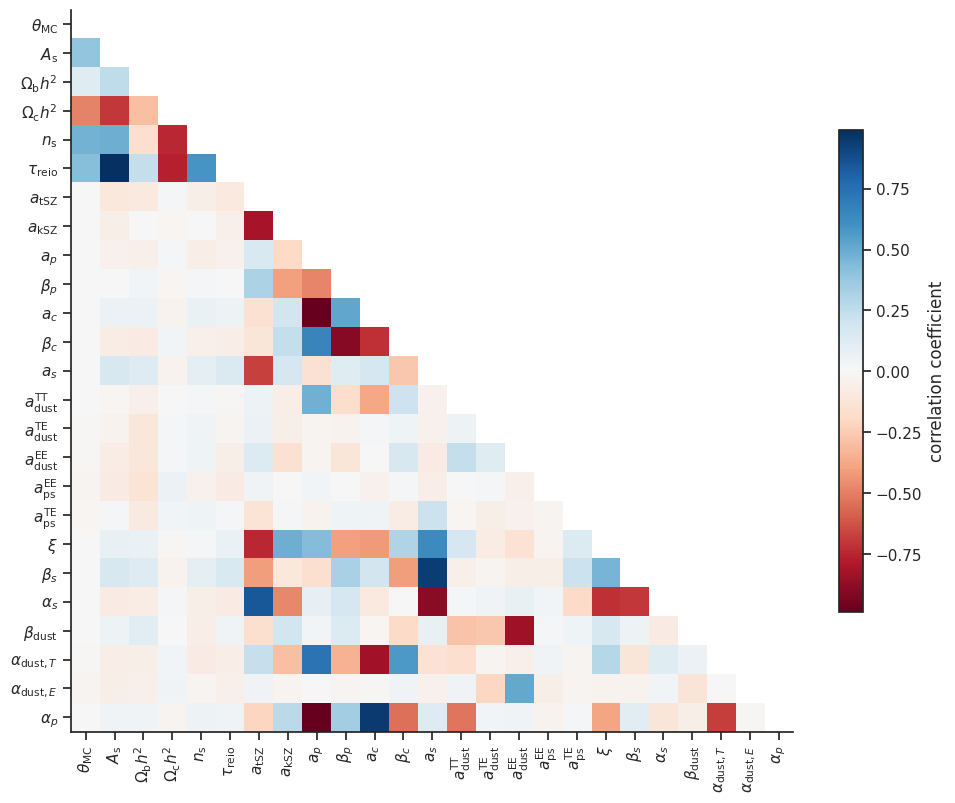

In [64]:
import matplotlib.pyplot as plt

cosmo_labels = dict(
    cosmomc_theta=r"\theta_\mathrm{MC}",
    As=r"A_\mathrm{s}",
    ns=r"n_\mathrm{s}",
    ombh2=r"\Omega_\mathrm{b}h^2",
    omch2=r"\Omega_\mathrm{c}h^2",
    tau=r"\tau_\mathrm{reio}",
)
labels = model.parameterization.labels() | cosmo_labels
latex_names = [rf"${labels[name]}$" for name in fisher_params]

fisher_sigmas = np.sqrt(np.diag(fisher_cov))
norm = np.outer(fisher_sigmas, fisher_sigmas)
fisher_corr = fisher_cov / norm

fig, ax = plt.subplots(figsize=(10, 10))
ind = np.triu_indices_from(fisher_corr)
fisher_corr[ind] = np.nan
im = ax.imshow(fisher_corr, cmap="RdBu")
ax.set_xticks(np.arange(nparams), latex_names, rotation=90)
ax.set_yticks(np.arange(nparams), latex_names, rotation=0)
fig.colorbar(im, shrink=0.5).set_label("correlation coefficient")

and the Fisher estimated noise

In [112]:
# LaTeX expressions do not render properly with pydata-sphinx-theme.
# It's long standing issue https://github.com/executablebooks/jupyter-book/issues/1826
# with no real solution except hacky's one. Here we convert LaTeX name of parameters to MathML
# equivalent and display the pandas dataframe with the styler class of pandas to render HTML code
# You need to pip install latex2mathml or change index to latex_names variable
# if you do not plan to generate documentation.
import pandas as pd
from latex2mathml.converter import convert

(
    pd.DataFrame(
        [
            [defaults[name], sigma, np.abs(defaults[name] / sigma)]
            for name, sigma in zip(fisher_params, fisher_sigmas)
        ],
        columns=["value", "σ", "Fisher S/N"],
        index=map(convert, [rf"{labels[name]}" for name in fisher_params]),
    )
    .sort_values("Fisher S/N", ascending=False)
    .style.format("{:e}", subset=["value", "σ"])
)

,value,σ,Fisher S/N
θMC,1.040920e-02,1.405784e-06,7404.553659
Ωbh2,2.237000e-02,6.408286e-05,349.079325
ns,9.649000e-01,3.217733e-03,299.869514
βp,2.200000e+00,1.226949e-02,179.306622
βs,-2.500000e+00,1.653964e-02,151.151996
Ωch2,1.200000e-01,1.104581e-03,108.638462
αs,1.000000e+00,9.758260e-03,102.477290
αp,1.000000e+00,1.849340e-02,54.073333
As,2.098903e-09,3.968838e-11,52.884576
βc,2.200000e+00,4.474972e-02,49.162314


Let's show the Signal over Noise ratio graphically



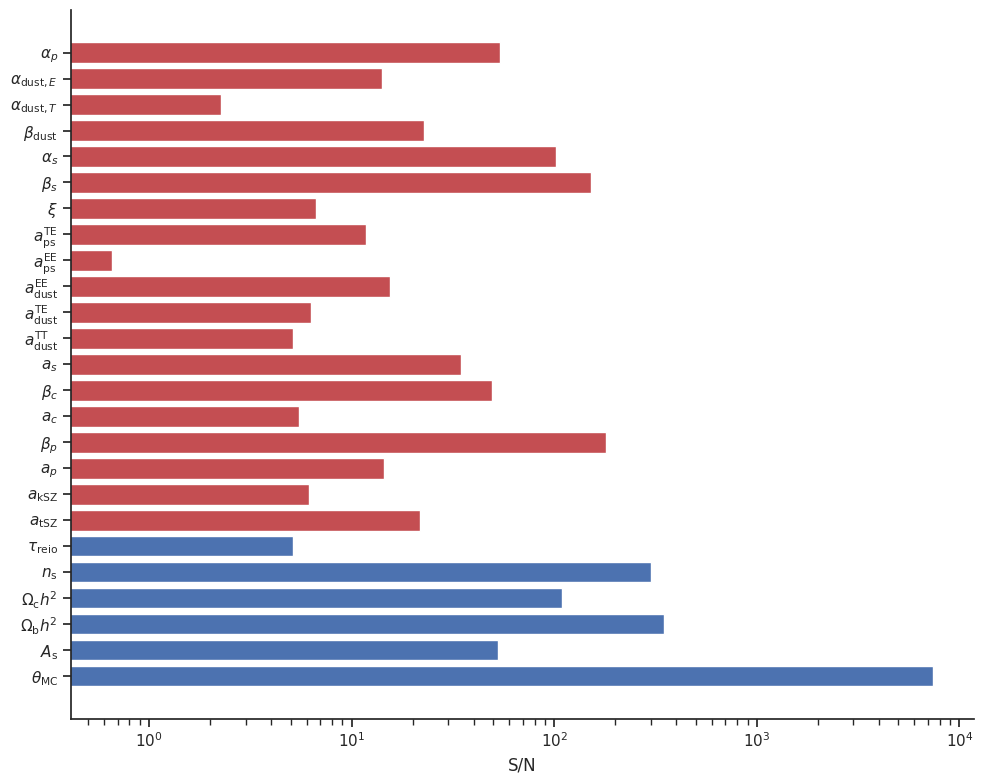

In [10]:
fig, ax = plt.subplots(figsize=(10, 8))
signal_over_noise = [np.abs(defaults[name] / sigma) for name, sigma in zip(fisher_params, fisher_sigmas)]
colors = ["b" if name in cosmo_params else "r" for name in fisher_params]
ax.barh(np.arange(nparams), signal_over_noise, color=colors)
ax.set(xscale="log", xlabel="S/N")
ax.set_yticks(range(len(fisher_params)), latex_names);

It also works for TT, TE or EE mode even if you keep the default list of sampled parameters. It will
only warn you about the fact that some parameters have no effect on power spectra and thus can be
removed from the sampled parameter list.

